In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
img_folder='/content/drive/MyDrive/sprints project /Scenes training set'
import splitfolders
splitfolders.ratio(img_folder, output="output",
    seed=1337, ratio=(.7,0.3), group_prefix=None, move=False)

Copying files: 14034 files [05:03, 46.31 files/s] 


In [4]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/drive/MyDrive/sprints project /testset'

In [68]:
from keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
 
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_dir,
                                            shuffle=False ,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 9820 images belonging to 6 classes.
Found 4214 images belonging to 6 classes.
Found 3050 images belonging to 1 classes.


In [50]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D

In [51]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

In [52]:
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

In [53]:
def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)
 
    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
 
    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)
 
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
 
    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)
 
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
 
    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])
 
    return x

In [54]:
def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
 
        tensor = Add()([tensor, x])
 
    return tensor

In [55]:
def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
 
    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)
 
    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=6, activation='softmax')(x)
 
    return x


In [56]:
input = Input(shape=[150, 150, 3])
 
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)
 
from tensorflow.keras import Model 
model = Model(input, output)

In [59]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.fit(training_set,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=val_set)

Epoch 1/12
307/307 [==============================] - 271s 695ms/step - loss: 1.6758 - accuracy: 0.4162 - val_loss: 8.0188 - val_accuracy: 0.2371
Epoch 2/12
307/307 [==============================] - 212s 690ms/step - loss: 1.1495 - accuracy: 0.5432 - val_loss: 1.6427 - val_accuracy: 0.4547
Epoch 3/12
307/307 [==============================] - 212s 689ms/step - loss: 1.0287 - accuracy: 0.5967 - val_loss: 1.0482 - val_accuracy: 0.5795
Epoch 4/12
307/307 [==============================] - 212s 689ms/step - loss: 0.8691 - accuracy: 0.6654 - val_loss: 1.8601 - val_accuracy: 0.4948
Epoch 5/12
307/307 [==============================] - 213s 692ms/step - loss: 0.7354 - accuracy: 0.7273 - val_loss: 1.0173 - val_accuracy: 0.6552
Epoch 6/12
307/307 [==============================] - 213s 692ms/step - loss: 0.6619 - accuracy: 0.7567 - val_loss: 0.8404 - val_accuracy: 0.7024
Epoch 7/12
307/307 [==============================] - 213s 693ms/step - loss: 0.6199 - accuracy: 0.7759 - val_loss: 0.6245 -

In [61]:
model.fit(training_set,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=val_set)

Epoch 1/12
307/307 [==============================] - 213s 693ms/step - loss: 0.4733 - accuracy: 0.8299 - val_loss: 0.9196 - val_accuracy: 0.7062
Epoch 2/12
307/307 [==============================] - 213s 693ms/step - loss: 0.4478 - accuracy: 0.8374 - val_loss: 0.6272 - val_accuracy: 0.7774
Epoch 3/12
307/307 [==============================] - 212s 689ms/step - loss: 0.4279 - accuracy: 0.8495 - val_loss: 0.5460 - val_accuracy: 0.8106
Epoch 4/12
307/307 [==============================] - 213s 691ms/step - loss: 0.4087 - accuracy: 0.8543 - val_loss: 1.0204 - val_accuracy: 0.7997
Epoch 5/12
307/307 [==============================] - 213s 692ms/step - loss: 0.4055 - accuracy: 0.8540 - val_loss: 0.9535 - val_accuracy: 0.7302
Epoch 6/12
307/307 [==============================] - 212s 689ms/step - loss: 0.3868 - accuracy: 0.8633 - val_loss: 1.0206 - val_accuracy: 0.7221
Epoch 7/12
307/307 [==============================] - 213s 691ms/step - loss: 0.3726 - accuracy: 0.8685 - val_loss: 1.2419 -

In [63]:
Xc= model.fit(training_set,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=val_set)

Epoch 1/5
307/307 [==============================] - 212s 690ms/step - loss: 0.3187 - accuracy: 0.8876 - val_loss: 1.2754 - val_accuracy: 0.6149
Epoch 2/5
307/307 [==============================] - 211s 686ms/step - loss: 0.3241 - accuracy: 0.8826 - val_loss: 7.2539 - val_accuracy: 0.5363
Epoch 3/5
307/307 [==============================] - 211s 687ms/step - loss: 0.2909 - accuracy: 0.8910 - val_loss: 0.6489 - val_accuracy: 0.7814
Epoch 4/5
307/307 [==============================] - 210s 684ms/step - loss: 0.2729 - accuracy: 0.9030 - val_loss: 0.4207 - val_accuracy: 0.8510
Epoch 5/5
307/307 [==============================] - 210s 685ms/step - loss: 0.2655 - accuracy: 0.9044 - val_loss: 0.4187 - val_accuracy: 0.8633


In [64]:
STEP_SIZE_VALID=val_set.n//val_set.batch_size
model.evaluate_generator(generator=val_set,
steps=STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.42033350467681885, 0.8625954389572144]

In [65]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
model.evaluate_generator(generator=training_set,
steps=STEP_SIZE_TRAIN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.28933998942375183, 0.8993055820465088]

In [70]:
import os 
import glob
import pandas as pd
import numpy as np 

Name = []

for img in glob.glob(test_dir):
    prediction = model.predict_generator(test_set,steps=150,verbose=1)
    for name in os.listdir('/content/drive/MyDrive/sprints project /testset/Scenes testing test'):
         Name.append(name[0::])



predicted_class_indics=np.argmax(prediction,axis=1)
Name.sort()
Temp = {'Image':Name, 'Label':predicted_class_indics}
temp = pd.DataFrame(Temp)
temp.to_csv('/content/results.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


 96/150 [==================>...........] - ETA: 6s

150/150 [==============================] - 12s 78ms/step


In [72]:

pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 321 kB 9.4 MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.37-py3-none-any.whl size=9408 sha256=da39ab3ef7c716f8768c33c7ddc6b6a9d3a31e53dda7e9ec75cf093cc829e0ff
  Stored in directory: /root/.cache/pip/wheels/72/91/3c/9306e573b56b6ea00e7d37c2286d51d1f8f2d7b1b078bf3399
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.49-py3-none-any.whl size=320403 sha256=843c747648a5dc5b54268ee833f5904204c79120d74f23143aef7b3b3996ff0b
  Stored in directory: /root/.cache/pip/wheels/f6/0a/7a/c00024468dd987395ee9bd54d293f6cc31f58da13dc2cfc5fc
  Created wheel for support-developer: filename=support_developer-1.0.3-py3-none-any.whl size=5202 sha256=8fdf1c0dddb2cd3ae641dfb7de30458a8fecb719ccc080eec0298cb5a4e66679
  Stored in directory: /root/.cache/pip/wheels/51/00/53/c6fb03c18816d1e57c3df9a0a2f77d5b1f697a60e132f5632d
  

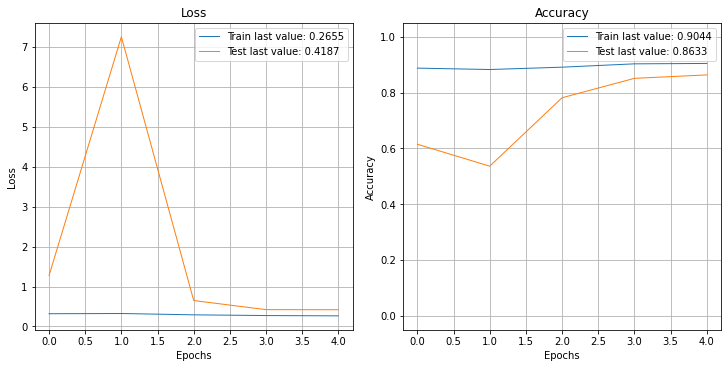

In [73]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt


show_history(Xc)
plot_history(Xc, path="standard.png")
plt.close()

